# Curve Fitting

We have introduced the analogy of machine learning essentially just being curve fitting with a large number of parameters. So in this notebook we will look into some of the basics of curve fitting, including:
- Brief reminder of terminology 
- Maximum likelihood
- $\chi^2$ test and Gaussian distribution
- Parameter estimation


## Gaussian distribution
In many circumstances we are dealing with data that can be well described by the Gaussian (normal) distribution. The probability distribution function for a Gaussian with mean $\mu$ and standard deviation $\sigma$ is 
$$P(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} $$

Now one common example of curve fitting is the case when we have some number, $N$, of data points, $x_i$, and we are interested in determining which values of $\mu$ and $\sigma$ are the ones which 'fit' our data (assuming the data are described by a Gaussian distribution.

## Maximum likelihood

To determine the likelihood of our data given a Gaussian hypothesis we can take the product of the individual probabilities
$$ L(x; \mu, \sigma) = \prod_i \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x_{i}-\mu}{\sigma}\right)^2} = \left( \frac{1}{\sigma \sqrt{2 \pi}}\right)^N e^{-\frac{1}{2} \sum_i (\frac{x_{i}-\mu}{\sigma})^2} $$

Whilst this seems like a bit of mess we can simplify things by taking the natural log of the likelihood (the log-likelihood).
$$ \ln L(x; \mu, \sigma) = N \ln \left( \frac{1}{\sigma \sqrt{2 \pi}}\right) -\sum_i \frac{1}{2} \left(\frac{x_{i}-\mu}{\sigma}\right)^2$$

Then if we want to find the value of $\mu$ that maximises the likelihood we can simply differentiate the log-likehood with respect to $\mu$.
$$ 0 = \frac{\partial \ln L}{\partial \mu} = - \sum_i \frac{1}{\sigma} \left(x_{i}-\mu\right)$$
which results in
$$\sum_i x_i = \sum_i \mu = N \mu$$
or $$ \mu = \frac{1}{N} \sum_i x_i$$

This is actually an illustration of an important feature of maximum likelihood estimation... in that it produces unbiased estimates of parameters.


## $\chi^2$ test

One interesting feature of our discussion of the log-likelihood of the Gaussian distributed data is that it naturally introduced the $\chi^2$ test statistic, which is effectively what we minimised above
$$ -2 \ln L \propto \chi^2 = \sum_i \left(\frac{x_{i}-\mu}{\sigma}\right)^2$$

The close connections between the $\chi^2$ test and the Gaussian log-likelihood unfortunately does tend to lead to a certain amount of sloppiness regarding language and often we will talk about likelihoods which aren't quite mathematically defined as such. Of course in the field of machine learning much of this confusion is washed away by the use of an entirely different set of jargon (e.g. cost functions).

The $\chi^2$ test is very similar to the least squares minimisation but due to its connection with the Gaussian probability distribution it has a number of interesting properties that we don't have the time or inclination to dwell on here. They are covered in detail in the fourth year statistical data analysis course.



## Gradient descent
We have already seen an example of gradient descent above. When we differentiated the log-likelihood with respect to the parameter $\mu$ we were effectively determining the gradient of our 'cost' function with respect to the model parameters. 

Now more genereally if we have a function of $x$ which depends on some number of parameters $\theta$ then we can define our $\chi^2$ as
$$ \chi^2 = \sum_i^N \left( \frac{f(x_i;\theta) - \tilde{f}}{\sigma} \right)^2 $$
where $\tilde{f}$ is the true distribution that we are trying to describe with $f(x_i;\theta)$. Ultimately we want to determine the parameters $\theta$ that minimise our $\chi^2$. So we want to find the gradient of $\chi^2$ with respect to $\theta$
$$ \frac{\partial \chi^2}{\partial \theta}  = \frac{\partial \chi^2}{\partial f}  \frac{\partial f}{\partial \theta}$$
$$ \frac{\partial \chi^2}{\partial \theta}  =  \sum_i^N 2 \left( \frac{f(x_i;\theta) - \tilde{f}}{\sigma} \right) \frac{\partial f}{\partial \theta} $$


## Stochastic gradient descent
In the above example our sum is implictly a sum over the full data set. In stochastic gradient descent instead of using the full dataset we instead use a small batch of data, say of size $n$, that is randomly sampled from the full data set. So we can using a sample of data determine our estimate of the gradient
$$ \left< \frac{\partial \chi^2}{\partial \theta} \right> = \sum_i^n \frac{2}{\sigma} \left(f(x_i;\theta) -\tilde{f}\right) \frac{\partial f}{\partial \theta}$$
or 
$$ \left< \frac{\partial \chi^2}{\partial \theta} \right> \propto \left< f(x_i;\theta) -\tilde{f}\right> \frac{\partial f}{\partial \theta} = \left< \Delta f\right> \frac{\partial f}{\partial \theta} $$
where the $\left< \right>$ represents the average over the batch of $n$ samples.

Using this gradient starting a some starting value of $\theta_i$ we can define an update rule to determine the next value of $\theta_{i+1}$ via
$$ \theta_{i+1} = \theta_{i} - \eta_i  \left< \Delta f\right> \frac{\partial f}{\partial \theta} $$
where $\eta_i$ is the *learning rate* which controls how big a step we take from one value of $\theta$ to the next. Now it is clear for sufficiently small values of the learning rate, $\eta_i$, this method will converge to a *local minimum* of our cost function (in the case the $\chi^2$). But if we choose too small a value of the learning rate we will obviously take too many steps and therefore waste a potential a huge amount of computational effort. As suggested by the subscript the optimum value of the learning rate typically changes depending on where we are in the *learning process*, e.g. how many steps we have taken in the minimisation. 

## Manual curve fitting example
Now we are going to actual run some code to try and do some actual curve fitting using the stochastic gradient descent method. This code is inspired by https://machine-learning-for-physicists.org/ and is released under the same Creative Commons Sharealike License. 
https://creativecommons.org/licenses/by-sa/4.0/

In [1]:
import numpy as np  #import the numpy library as np
import matplotlib.pyplot as plt #import the pyplot library as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


Let's start by looking at a simple non linear function that depends on two parameters $\theta_1$ and $\theta_2$, $$f(x,\theta_1,\theta_2) = \frac {\theta_1}{\left(\theta_2-x\right)^2 +1}$$

One advantage of this function is that we can differentiate it analytically with respect to the parameters theta
$$ \frac{\partial f}{\partial \theta_1} = \frac {1}{\left(\theta_2-x\right)^2 +1}$$
$$ \frac{\partial f}{\partial \theta_2} = \frac {2\left(x-\theta_2\right)\theta_1}{\left(\left(\theta_2-x\right)^2 +1\right)^2}$$

In [2]:
def f(x,theta):
    """
    This is a function which calculates
        .. math::
            f(x,\theta_1,\theta_2) = \frac {\theta_1}{\left(\theta_2-x\right)^2 +1} 
    Args:
        x: A numpy array of x values
        theta: a list of [theta1,theta2]

    Returns:
        A numpy array of f(x,theta)
    """
    return (theta[0])/(((theta[1]-x)**2)+1.0)
    

def grad_f(x,theta):
    """
    This is a function which calculates
        .. math::
            \frac{\partial f}{\partial \theta_1} = \frac {1}{\left(\theta_2-x\right)^2 +1}
            \frac{\partial f}{\partial \theta_2} = \frac {2\left(x-\theta_2\right)\theta_1}{\left(\left(\theta_2-x\right)^2 +1\right)^2}
            
    Args:
        x: A numpy array of x values
        theta: a list of [theta1,theta2]

    Returns:
        A 2D numpy array of [df/dtheta1(x,theta),df/dtheta2]
    """
    return np.array([1/((theta[1]-x)**2 +1.0),  2*(x-theta[1])*theta[0]/((theta[1]-x)**2+1.0)**2])
   

def true_f(x):
    """
    This is a function which calls f(x,theta) with theta=[2,0.5]
    Args:
        x: A numpy array of x values

    Returns:
        A numpy array of f(x,[2,0.5])
    """
    return f(x,[2.0,0.5])

# Get randomly sampled x values
def samples(nsamples,width=2.0):
    """
    Returns an array of random numbers from 
    Args:
        nsamples: The length of the random samples array

    Returns:
        A numpy array of f(x,[2,0.5])
    """
    return(width*np.random.randn(nsamples))

def get_avg_fake_chisq(x, theta):
    """
    Returns the average fake chi-squared
        .. math::
            \chi^2 (x,\theta) = \frac{\sum_i=1^N \left(f(x,\theta) - f(2,0.5) \right)^2}{N}  
    Args:
        x: A numpy array of x values
        theta: a list of [theta1,theta2]

    Returns:
        A single number the fake chisquared (it is fake because we have set sigma to 1)
    """
    return np.average((f(x,theta)-true_f(x))**2)

def get_2d_chisquared(theta0Vals,theta1Vals,numSamples):
    """
    Returns a 2D array of fake chisquared values
    Args:
        theta0Vals: An array of the theta0 values
        theta1Vals: An array of the theta1 values
        numSamples: Number of random samples to take at each point

    Returns:
        A 2d array of fake_chisqaured evaluated at each pair of theta values
    """
    N0=len(theta0Vals)  # Length of theta0Vals array
    N1=len(theta1Vals)  # Length of theta1Vals array
    output=np.zeros((N0,N1)) # 2D array for output values
    for j0 in range(N0): # Loop over theta0 indices
        for j1 in range(N1): # Loop over theta1 indices
            theta=np.array([theta0Vals[j0],theta1Vals[j1]])  # Temp theta array
            x=samples(numSamples) # Get numSamples random numbers
            output[j0,j1]=get_avg_fake_chisq(x,theta) # Calculate the fake chisquared
    return(output)


In [3]:
#Just to remind ourselves of what shape the numpy arrays are
x=np.linspace(-10,10,100)  #Get 100 points from -10 to 10
print("x.shape",x.shape)
print("f.shape",f(x,[1,-3]).shape)
print("grad_f.shape",grad_f(x,[1,-3]).shape)

x.shape (100,)
f.shape (100,)
grad_f.shape (2, 100)


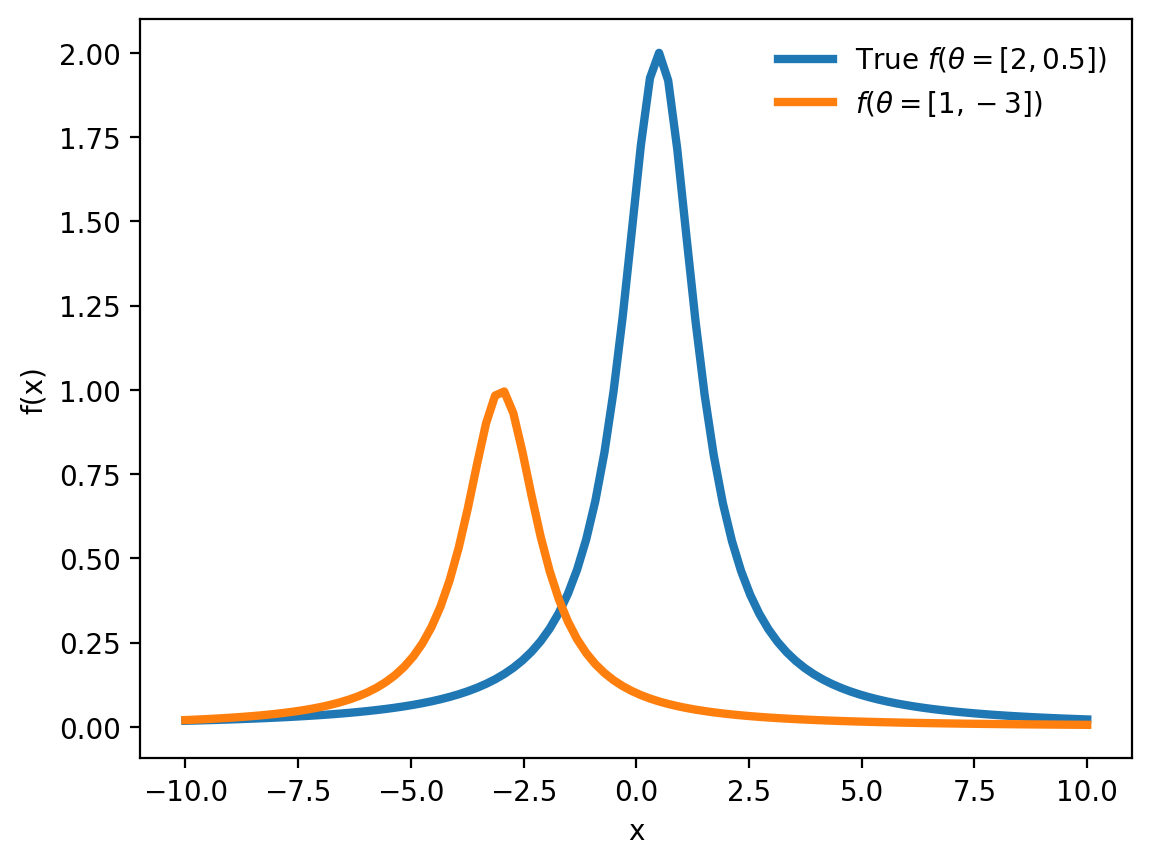

In [4]:
#Here we will plot our true function with theta=[2,0.5] and one with theta=[1,-3]
fig, ax = plt.subplots()  #I like to make plots using this silly fig,ax method but plot how you like
ax.plot(x,true_f(x),linewidth=3,label=r"True $f(\theta=[2,0.5])$")
ax.plot(x,f(x,[1,-3]),linewidth=3,label=r'$f(\theta=[1,-3])$')
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.legend()

## Plot the likelihood (fake chisquared) surface
In this section we will plot what the chisquared surface in $\theta_0$ vs $\theta_1$ space

Text(0, 0.5, '$\\theta_1$')

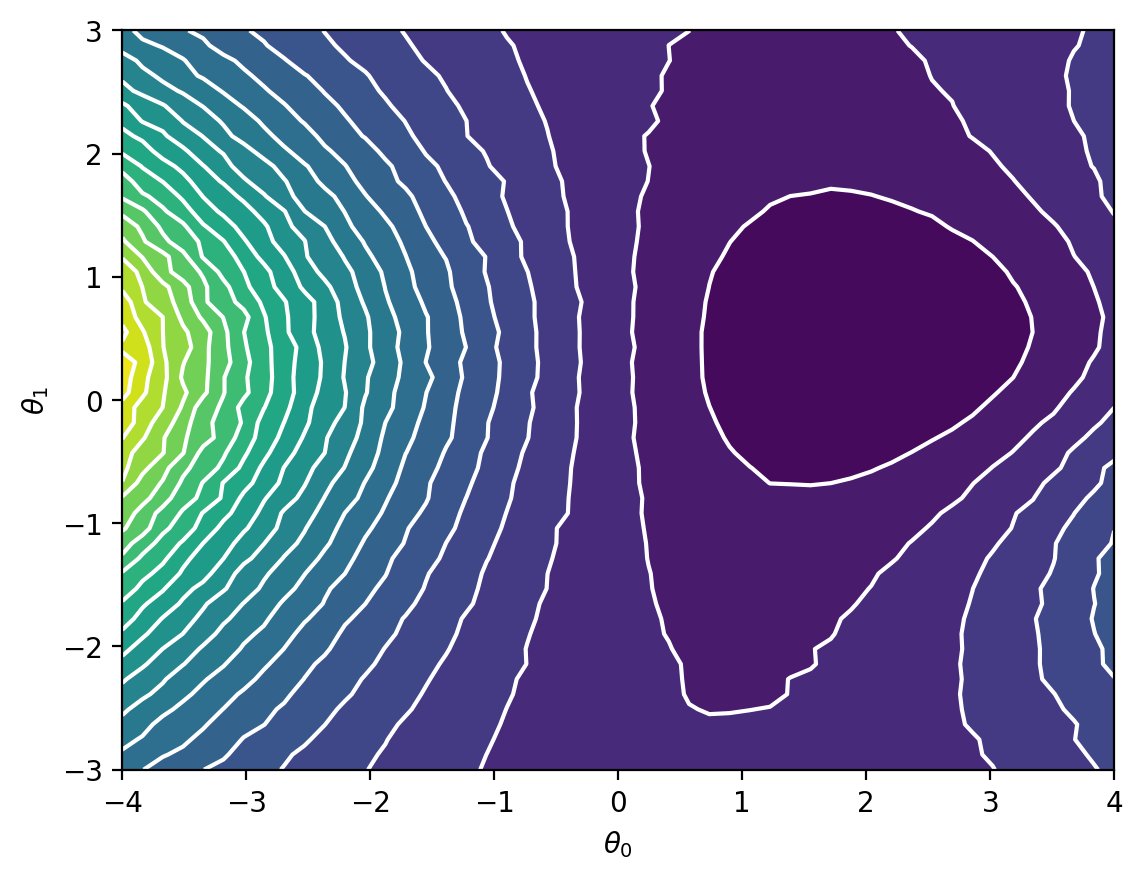

In [9]:
# Now we are going to get a 2D map of our (fake) chisquared over a range of theta0,theta1 space  
theta0Vals=np.linspace(-4,4,50) #Get 50 theta0 values from -4 to +4
theta1Vals=np.linspace(-3,3,50) #Get 50 theta1 values from -3 to +3
chi2=get_2d_chisquared(theta0Vals,theta1Vals,10000) #Generate the fake chi-squared map with 10000 random samples per point
X,Y=np.meshgrid(theta0Vals,theta1Vals,indexing='ij') # X,Y are both
nlevels=20 # Number of levels (white lines on plots) we will use for the contour plot
fig, ax = plt.subplots() #Get the fig and ax objects for the plot 
ax.contourf(X,Y,chi2,nlevels) #Plot filled contours (colour map below)
ax.contour(X,Y,chi2,nlevels,colors="white") #Plot line contours (white lines below)
ax.set_xlabel(r"$\theta_0$") #Label the axis
ax.set_ylabel(r"$\theta_1$") #Label the axis


## Stochastic gradient descent
Now we will try and implement a stochastic gradient descent algorithm

In [6]:
numSteps=150 #Number of steps in our stochastic gradient descent algorithm
theta=[-3,0.5] #Starting place, you can change this and see what happens
eta=0.1 #'Learning' rate, how far do we step each time
chiSqArray=np.zeros(numSteps)  #Array for plotting
thetaArray=np.zeros((numSteps+1,2))  #Array for plotting 
thetaArray[0]=theta #Starting step


for i in range(numSteps): #Loop over i from 0 to numSteps-1
    x=samples(10) # Generate 10 random samples... change this number to see what happens
    chiSq=get_avg_fake_chisq(x,theta)  #Get chisquared for these fake samples
    chiSqArray[i]=chiSq #For plotting
    #Work out difference to true function
    deviation=f(x,theta)-true_f(x)
    #Now work out where do go next
    theta-=eta*np.average(deviation[None,:]*grad_f(x,theta),axis=1)
    thetaArray[i+1]=theta  #For plotting
    

Text(0, 0.5, '(Fake) $\\chi^2$')

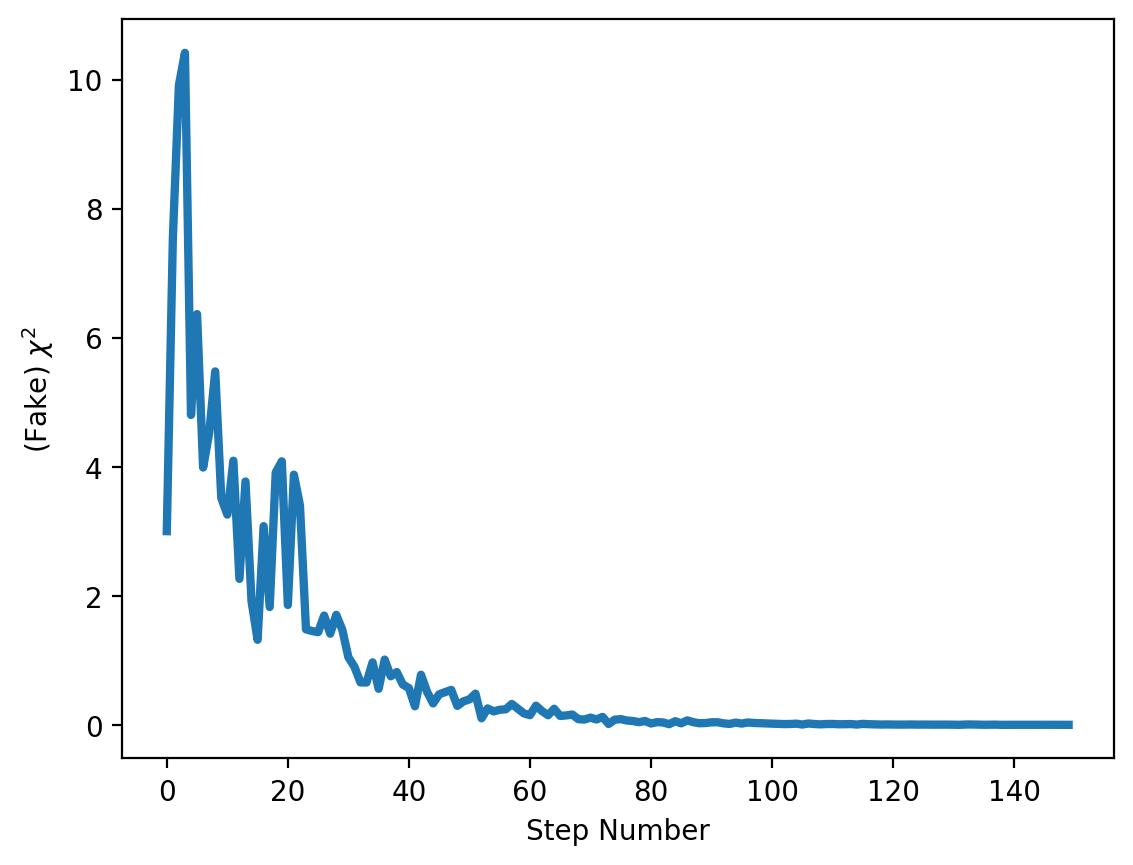

In [7]:
# First plot is going to be step number vs chisquared
fig, ax = plt.subplots()  #I like to make plots using this silly fig,ax method but plot how you like
count=np.arange(numSteps+1)  #The integers from 0 up to num steps
ax.plot(count[:-1],chiSqArray,linewidth=3)
ax.set_xlabel("Step Number")
ax.set_ylabel(r"(Fake) $\chi^2$")

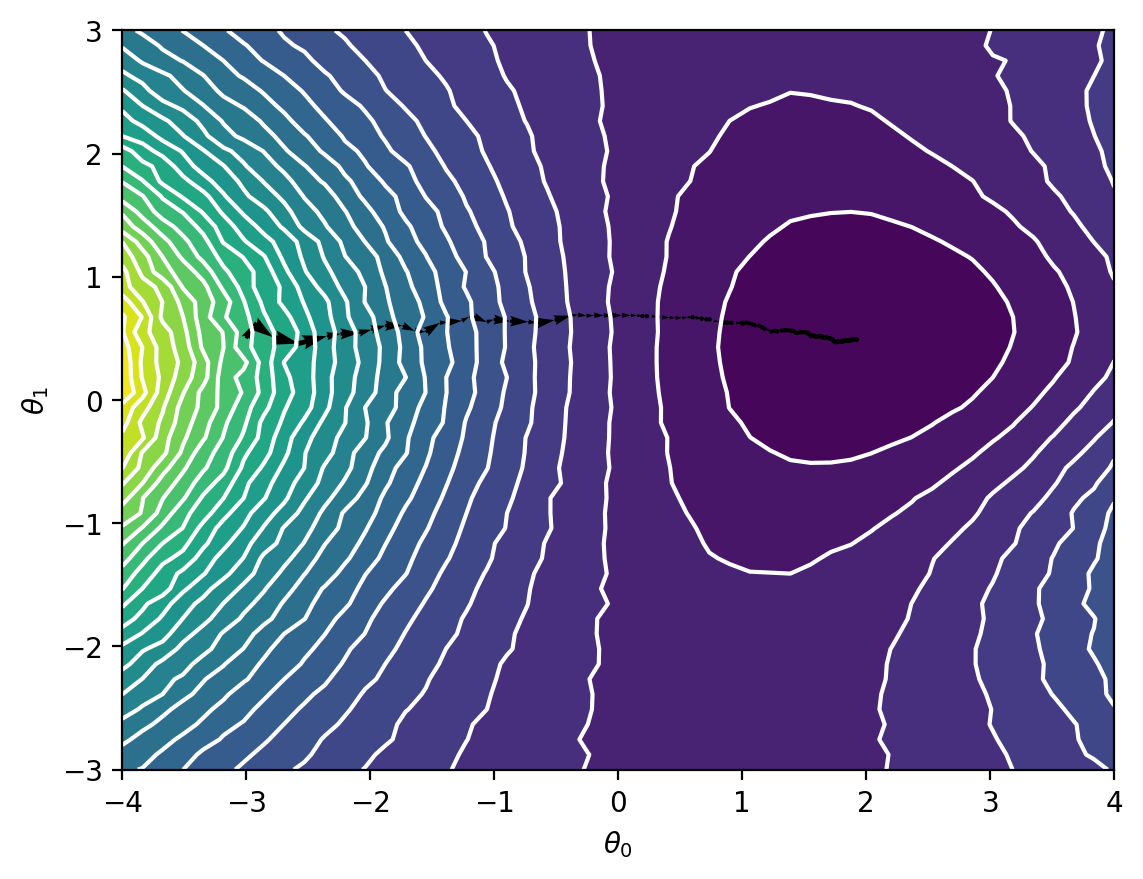

In [8]:
# Now we are going to get a 2D map of our (fake) chisquared over a range of theta0,theta1 space  
# And overlay the steps taken by the stochastic gradient descent algorithm
fig, ax = plt.subplots() #Get the fig and ax objects for the plot 
ax.contourf(X,Y,chi2,nlevels)
ax.contour(X,Y,chi2,nlevels,colors="white")
ax.set_xlabel(r"$\theta_0$")
ax.set_ylabel(r"$\theta_1$")
ax.quiver(thetaArray[:-1,0], thetaArray[:-1,1], thetaArray[1:,0]-thetaArray[:-1,0], thetaArray[1:,1]-thetaArray[:-1,1], scale_units='xy',scale=1)


# Suggested Tasks
So we have successfully achieved our first ever optimisation. Things to try:
- Investigate the 'stability' of the fit: does it always converge to the correct place?
    - You could try changing the learning rate or the number of samples or the starting location or true location
- From the same starting place what is the optimal number of samples and learning rate to get close to the true answer. Here close means that the deviation from true $f$ is less than some (arbritrary but small) threshold.    
- Try to add 'noise' to the determination of the function (e.g. add some Gaussian noise to the result of the function f
- Try some different functions, why didn't we start with this function?  $$f(x,\theta_1,\theta_2) = \frac {\theta_1}{\left(\theta_2-x\right)^2}$$
- What about this function? $$\frac{\sin(\theta_1 (x-\theta_0))}{5+x^2}$$

